In [1]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import packages
import pytesseract
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import re
import os
import shutil
from google.colab import drive
import datetime


In [24]:
#this will connect to your Google Drive. It will ask you to allow access
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [35]:
# create a file list data frame to keep the old-name -> new-name conversions and status 
file_names_list = []

In [87]:
def unzip_src(folder):
      """
  Unzip zipped folder.

  A zipped folder is taken in and unzipped.

  Parameter
  ---------
  kind : Google Drive Folder
    Folder containing watershed photos.

  Returns
  -------
  new_src : new src for unzipped folder.
  unzipped : unzipped folder.

  """
  new_src = folder
  unzipped = None

  if folder[-4:] == '.zip':
    src_as_zip = True
    unzipped = folder[:-4]
    shutil.unpack_archive(folder, unzipped)

    parentZip = np.array(os.listdir(unzipped))
    new_src = unzipped + '/' + parentZip[0]
  
  return new_src, unzipped


def new_folder(src, dst = None):
  '''
  Create a new folder destination address for folder to be copied.

  This method's parameter is the address of folder you're going to copy, address of destination parent folder
  It will return the name of folder (to use later), full new address of copy folder 
  determines new folder address.

  Parameters
  ----------
  src : src address for folder to be copied.
  dst : destination address for folder to be copied.

  Returns
  -------
  folder_name : the new folders name.
  newAddress : the full new address of copy folder.
  '''
  if dst is None:
    dst = src
  # print(src, "Src")
  src_elements = src.split('/')
  folder_name = src_elements[-1][:2]
  # print(folder_name, "Folder")
  newAddress = dst + "/" + folder_name
  return folder_name, newAddress


def generate_picName(fdr_name, tStamp):
  '''
  Generate standardized picture names.

  The full source address of a pciture file and its time stamp are standardized 
  to a format delineated by water shed number and time stamp. 

  Parameters
  ----------
  fdr_name : full source address of current picture file.
  tStamp : unaltered timeStamp from bottom of the photo
      as a string.

  Returns
  -------
  new_name : new name of picture
  '''
  ws_num = fdr_name[1] #!!!this should be changed if src_elements[-2][1] will not be watershed number!!

  stamp_elements = re.split('[\n: -]', tStamp)
  date = stamp_elements[2] + stamp_elements[0] + stamp_elements[1]
  time = stamp_elements[3] + stamp_elements[4] + stamp_elements[5]

  new_name = "Hbwtr_w" + ws_num + '_' + date + '_' + time + '.JPG'
  return new_name

def extract_timeStamp(pic_address):
    '''
    Extract time Stamp from picture file.

    From the bottom right of each picture file, the time stamp is read as image using cv2. It is then converted to a string.
    text which is then checked for format and subsequently returned through match_date_format.

    Parameters
    ----------
    pic_address : full source address of current picture file.
    Returns
    -------
    match_date_format.group(0) : unaltered timeStamp from bottom of the photo as a string.
    '''
    # print(pic_address)
    img = cv2.imread(pic_address) #read as an image
    ts = img[2352:, 2000:, :] #(change if sizing conventions change!)
    text = pytesseract.image_to_string(ts)
    print(text)
    # check if the timestamp is the correct format
    date_pattern = "\d\d-\d\d-\d\d\d\d \d\d:\d\d:\d\d" # eg 12-12-2020 11:59:32
    match_date_format = re.search(date_pattern,text)
    if not match_date_format:
      print("Correct timestamp not found")
    else:
      return match_date_format.group(0)

def rename_images(picFolder, fdr_name, fdr_dst):

  '''
  Rename all files in the current folder and populate the list of old and new names.

  For each picture file in the current folder, its filename is changed and its new name is generated in another method.
  The old image is copied to its new destination.

  Parameters
  ----------
  picFolder : a folder containing pictures.
  fdr_name : full address of folder.
  fdr_dst : full destination address.
  '''

  picFiles = np.array(os.listdir(picFolder))
  # print(picFiles, len(picFiles))
  old_folder = "/".join(picFolder.split("/")[-3:-1])

  for filename in picFiles:
    old_name = filename
    new_name = np.nan
    status="raw"
    note = np.nan
    print("Old filename", filename) #just to track where you are
    src = picFolder + '/' + filename #old img address
    # print(src)
    filetype = filename[-4:]
    try:
      if (filetype == '.JPG') or (filetype == '.jpg'):
        tStamp = extract_timeStamp(src)
        new_name = generate_picName(fdr_name, tStamp)
        print("New filename", new_name)
        status = "renamed"
        dst = fdr_dst + '/' + filename #new img address
        dst_renamed = fdr_dst + '/' + new_name #img new address + name
        shutil.copy(src, dst_renamed) #copies old image to new destination

        # os.rename(src, dst) #renames file in Google Drive
      else:
        print("Not image file")
        status= "error"
        note = "Not image file"
    except:
      print("Unable to process file")
      status = "error"
      note =  "Unable to process file"
    curr_list = [old_name, new_name, status, note, picFolder]
    file_names_list.append(curr_list)



In [37]:
# MAIN

from glob import glob

#collect all folder paths from newly uploaded data on folder
folder_list = glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Newly_uploaded_data/*/", recursive = True)
# collect all folder path from on deck folder
folder_list.extend(glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/On_Deck/*/", recursive = True))

# extract folder_name 
folder_list = [f[:-1] for f in folder_list]

# for each folder rename and add them to the new destination - dst
for folder in folder_list:
  dst = "/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Testing destination"
  save_as_zip = False

  #will unzip if necessary
  folder, unzipped = unzip_src(folder)

  # #create new destination folder
  fdr_name, fdr_dst = new_folder(folder, dst)

  if os.path.exists(fdr_dst):
    print("path already exists")
  else:
    print("new path")
    os.mkdir(fdr_dst)

  rename_images(folder, fdr_name, fdr_dst)

new path
Old filename 05100001.JPG
New filename Hbwtr_w3_20210510_115949.JPG
Old filename 05110003.JPG
New filename Hbwtr_w3_20210511_115948.JPG
Old filename 05120005.JPG
New filename Hbwtr_w3_20210512_115948.JPG
Old filename 05130008.JPG
New filename Hbwtr_w3_20210513_115947.JPG
Old filename 05140011.JPG
New filename Hbwtr_w3_20210514_115947.JPG
Old filename 05150013.JPG
New filename Hbwtr_w3_20210515_115946.JPG
Old filename 05160015.JPG
New filename Hbwtr_w3_20210516_115946.JPG
Old filename 05170018.JPG
New filename Hbwtr_w3_20210517_115945.JPG
Old filename 05180020.JPG
New filename Hbwtr_w3_20210518_115945.JPG
Old filename 05190023.JPG
New filename Hbwtr_w3_20210519_120444.JPG
Old filename 05200024.JPG
New filename Hbwtr_w3_20210520_115943.JPG
Old filename 05210026.JPG
New filename Hbwtr_w3_20210521_115943.JPG
Old filename 05220029.JPG
New filename Hbwtr_w3_20210522_120442.JPG
Old filename 05230031.JPG
New filename Hbwtr_w3_20210523_120442.JPG
Old filename 05240032.JPG
New filename 

In [38]:
# file_list data frame
file_df = pd.DataFrame(file_names_list, columns = ["old_name","new_name", "status", "note","old_folder"])
file_df

old_name                                   old_folder  \
0    05100001.JPG  COPY of data for script/Newly_uploaded_data   
1    05110003.JPG  COPY of data for script/Newly_uploaded_data   
2    05120005.JPG  COPY of data for script/Newly_uploaded_data   
3    05130008.JPG  COPY of data for script/Newly_uploaded_data   
4    05140011.JPG  COPY of data for script/Newly_uploaded_data   
..            ...                                          ...   
872  01190387.JPG              COPY of data for script/On_Deck   
873  01270406.JPG              COPY of data for script/On_Deck   
874  02020417.JPG              COPY of data for script/On_Deck   
875  01220394.JPG              COPY of data for script/On_Deck   
876   desktop.ini              COPY of data for script/On_Deck   

                         new_name   status            note  
0    Hbwtr_w3_20210510_115949.JPG  renamed             NaN  
1    Hbwtr_w3_20210511_115948.JPG  renamed             NaN  
2    Hbwtr_w3_20210512_115948.JPG  renamed             NaN  
3    Hbwtr_w3_20210513_115947.JPG  renamed             NaN  
4    Hbwtr_w3_20210514_115947.JPG  renamed             NaN  
..                            ...      ...             ...  
872  Hbwtr_w2_20190119_115812.JPG  renamed             NaN  
873  Hbwtr_w2_20190127_120450.JPG  renamed             NaN  
874  Hbwtr_w2_20190202_115933.JPG  renamed             NaN  
875  Hbwtr_w2_20190122_115803.JPG  renamed             NaN  
876                           NaN    error  Not image file  

[877 rows x 5 columns]

In [39]:
# files with error status
file_df[file_df.status=="error"]

old_name                                   old_folder new_name  \
164  10250350.JPG  COPY of data for script/Newly_uploaded_data      NaN   
165   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
166   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
168  11080004.JPG  COPY of data for script/Newly_uploaded_data      NaN   
170  11100008.JPG  COPY of data for script/Newly_uploaded_data      NaN   
..            ...                                          ...      ...   
356   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
425   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
427   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
604   desktop.ini  COPY of data for script/Newly_uploaded_data      NaN   
876   desktop.ini              COPY of data for script/On_Deck      NaN   

    status                    note  
164  error  Unable to process file  
165  error          Not image file  
166  error          Not image file  
168  error  Unable to process file  
170  error  Unable to process file  
..     ...                     ...  
356  error          Not image file  
425  error          Not image file  
427  error          Not image file  
604  error          Not image file  
876  error          Not image file  

[61 rows x 5 columns]

In [41]:
# files unable to process
file_df[file_df.note=="Unable to process file"]

old_name                                   old_folder new_name  \
164  10250350.JPG  COPY of data for script/Newly_uploaded_data      NaN   
168  11080004.JPG  COPY of data for script/Newly_uploaded_data      NaN   
170  11100008.JPG  COPY of data for script/Newly_uploaded_data      NaN   
173  11130014.JPG  COPY of data for script/Newly_uploaded_data      NaN   
174  11140017.JPG  COPY of data for script/Newly_uploaded_data      NaN   
179  11190027.JPG  COPY of data for script/Newly_uploaded_data      NaN   
182  11220033.JPG  COPY of data for script/Newly_uploaded_data      NaN   
184  11240037.JPG  COPY of data for script/Newly_uploaded_data      NaN   
189  11290047.JPG  COPY of data for script/Newly_uploaded_data      NaN   
193  12030056.JPG  COPY of data for script/Newly_uploaded_data      NaN   
208  12170086.JPG  COPY of data for script/Newly_uploaded_data      NaN   
212  12210094.JPG  COPY of data for script/Newly_uploaded_data      NaN   
214  12230098.JPG  COPY of data for script/Newly_uploaded_data      NaN   
220  12290110.JPG  COPY of data for script/Newly_uploaded_data      NaN   
222  12310114.JPG  COPY of data for script/Newly_uploaded_data      NaN   
229  01070128.JPG  COPY of data for script/Newly_uploaded_data      NaN   
230  01080130.JPG  COPY of data for script/Newly_uploaded_data      NaN   
235  01130140.JPG  COPY of data for script/Newly_uploaded_data      NaN   
239  01170148.JPG  COPY of data for script/Newly_uploaded_data      NaN   
240  01180150.JPG  COPY of data for script/Newly_uploaded_data      NaN   
241  01190153.JPG  COPY of data for script/Newly_uploaded_data      NaN   
242  01200155.JPG  COPY of data for script/Newly_uploaded_data      NaN   
243  01210156.JPG  COPY of data for script/Newly_uploaded_data      NaN   
244  01220158.JPG  COPY of data for script/Newly_uploaded_data      NaN   
245  01230160.JPG  COPY of data for script/Newly_uploaded_data      NaN   
246  01240162.JPG  COPY of data for script/Newly_uploaded_data      NaN   
248  01260166.JPG  COPY of data for script/Newly_uploaded_data      NaN   
249  01270169.JPG  COPY of data for script/Newly_uploaded_data      NaN   
254  02010178.JPG  COPY of data for script/Newly_uploaded_data      NaN   
256  02030182.JPG  COPY of data for script/Newly_uploaded_data      NaN   
257  02040184.JPG  COPY of data for script/Newly_uploaded_data      NaN   
259  02060188.JPG  COPY of data for script/Newly_uploaded_data      NaN   
260  02070190.JPG  COPY of data for script/Newly_uploaded_data      NaN   
262  02090194.JPG  COPY of data for script/Newly_uploaded_data      NaN   
264  02110198.JPG  COPY of data for script/Newly_uploaded_data      NaN   
265  02120200.JPG  COPY of data for script/Newly_uploaded_data      NaN   
267  02140204.JPG  COPY of data for script/Newly_uploaded_data      NaN   
268  02150206.JPG  COPY of data for script/Newly_uploaded_data      NaN   
269  02160208.JPG  COPY of data for script/Newly_uploaded_data      NaN   
271  02180212.JPG  COPY of data for script/Newly_uploaded_data      NaN   
272  02190214.JPG  COPY of data for script/Newly_uploaded_data      NaN   
275  02220220.JPG  COPY of data for script/Newly_uploaded_data      NaN   
280  02270230.JPG  COPY of data for script/Newly_uploaded_data      NaN   
284  03030238.JPG  COPY of data for script/Newly_uploaded_data      NaN   
292  03100253.JPG  COPY of data for script/Newly_uploaded_data      NaN   
298  03160265.JPG  COPY of data for script/Newly_uploaded_data      NaN   
301  03190271.JPG  COPY of data for script/Newly_uploaded_data      NaN   
302  03200273.JPG  COPY of data for script/Newly_uploaded_data      NaN   
311  03290291.JPG  COPY of data for script/Newly_uploaded_data      NaN   
319  04060307.JPG  COPY of data for script/Newly_uploaded_data      NaN   
341  04270352.JPG  COPY of data for script/Newly_uploaded_data      NaN   
350  05060371.JPG  COPY of data for script/Newly_uploaded_data      NaN   

    status                    not

file_exists: True


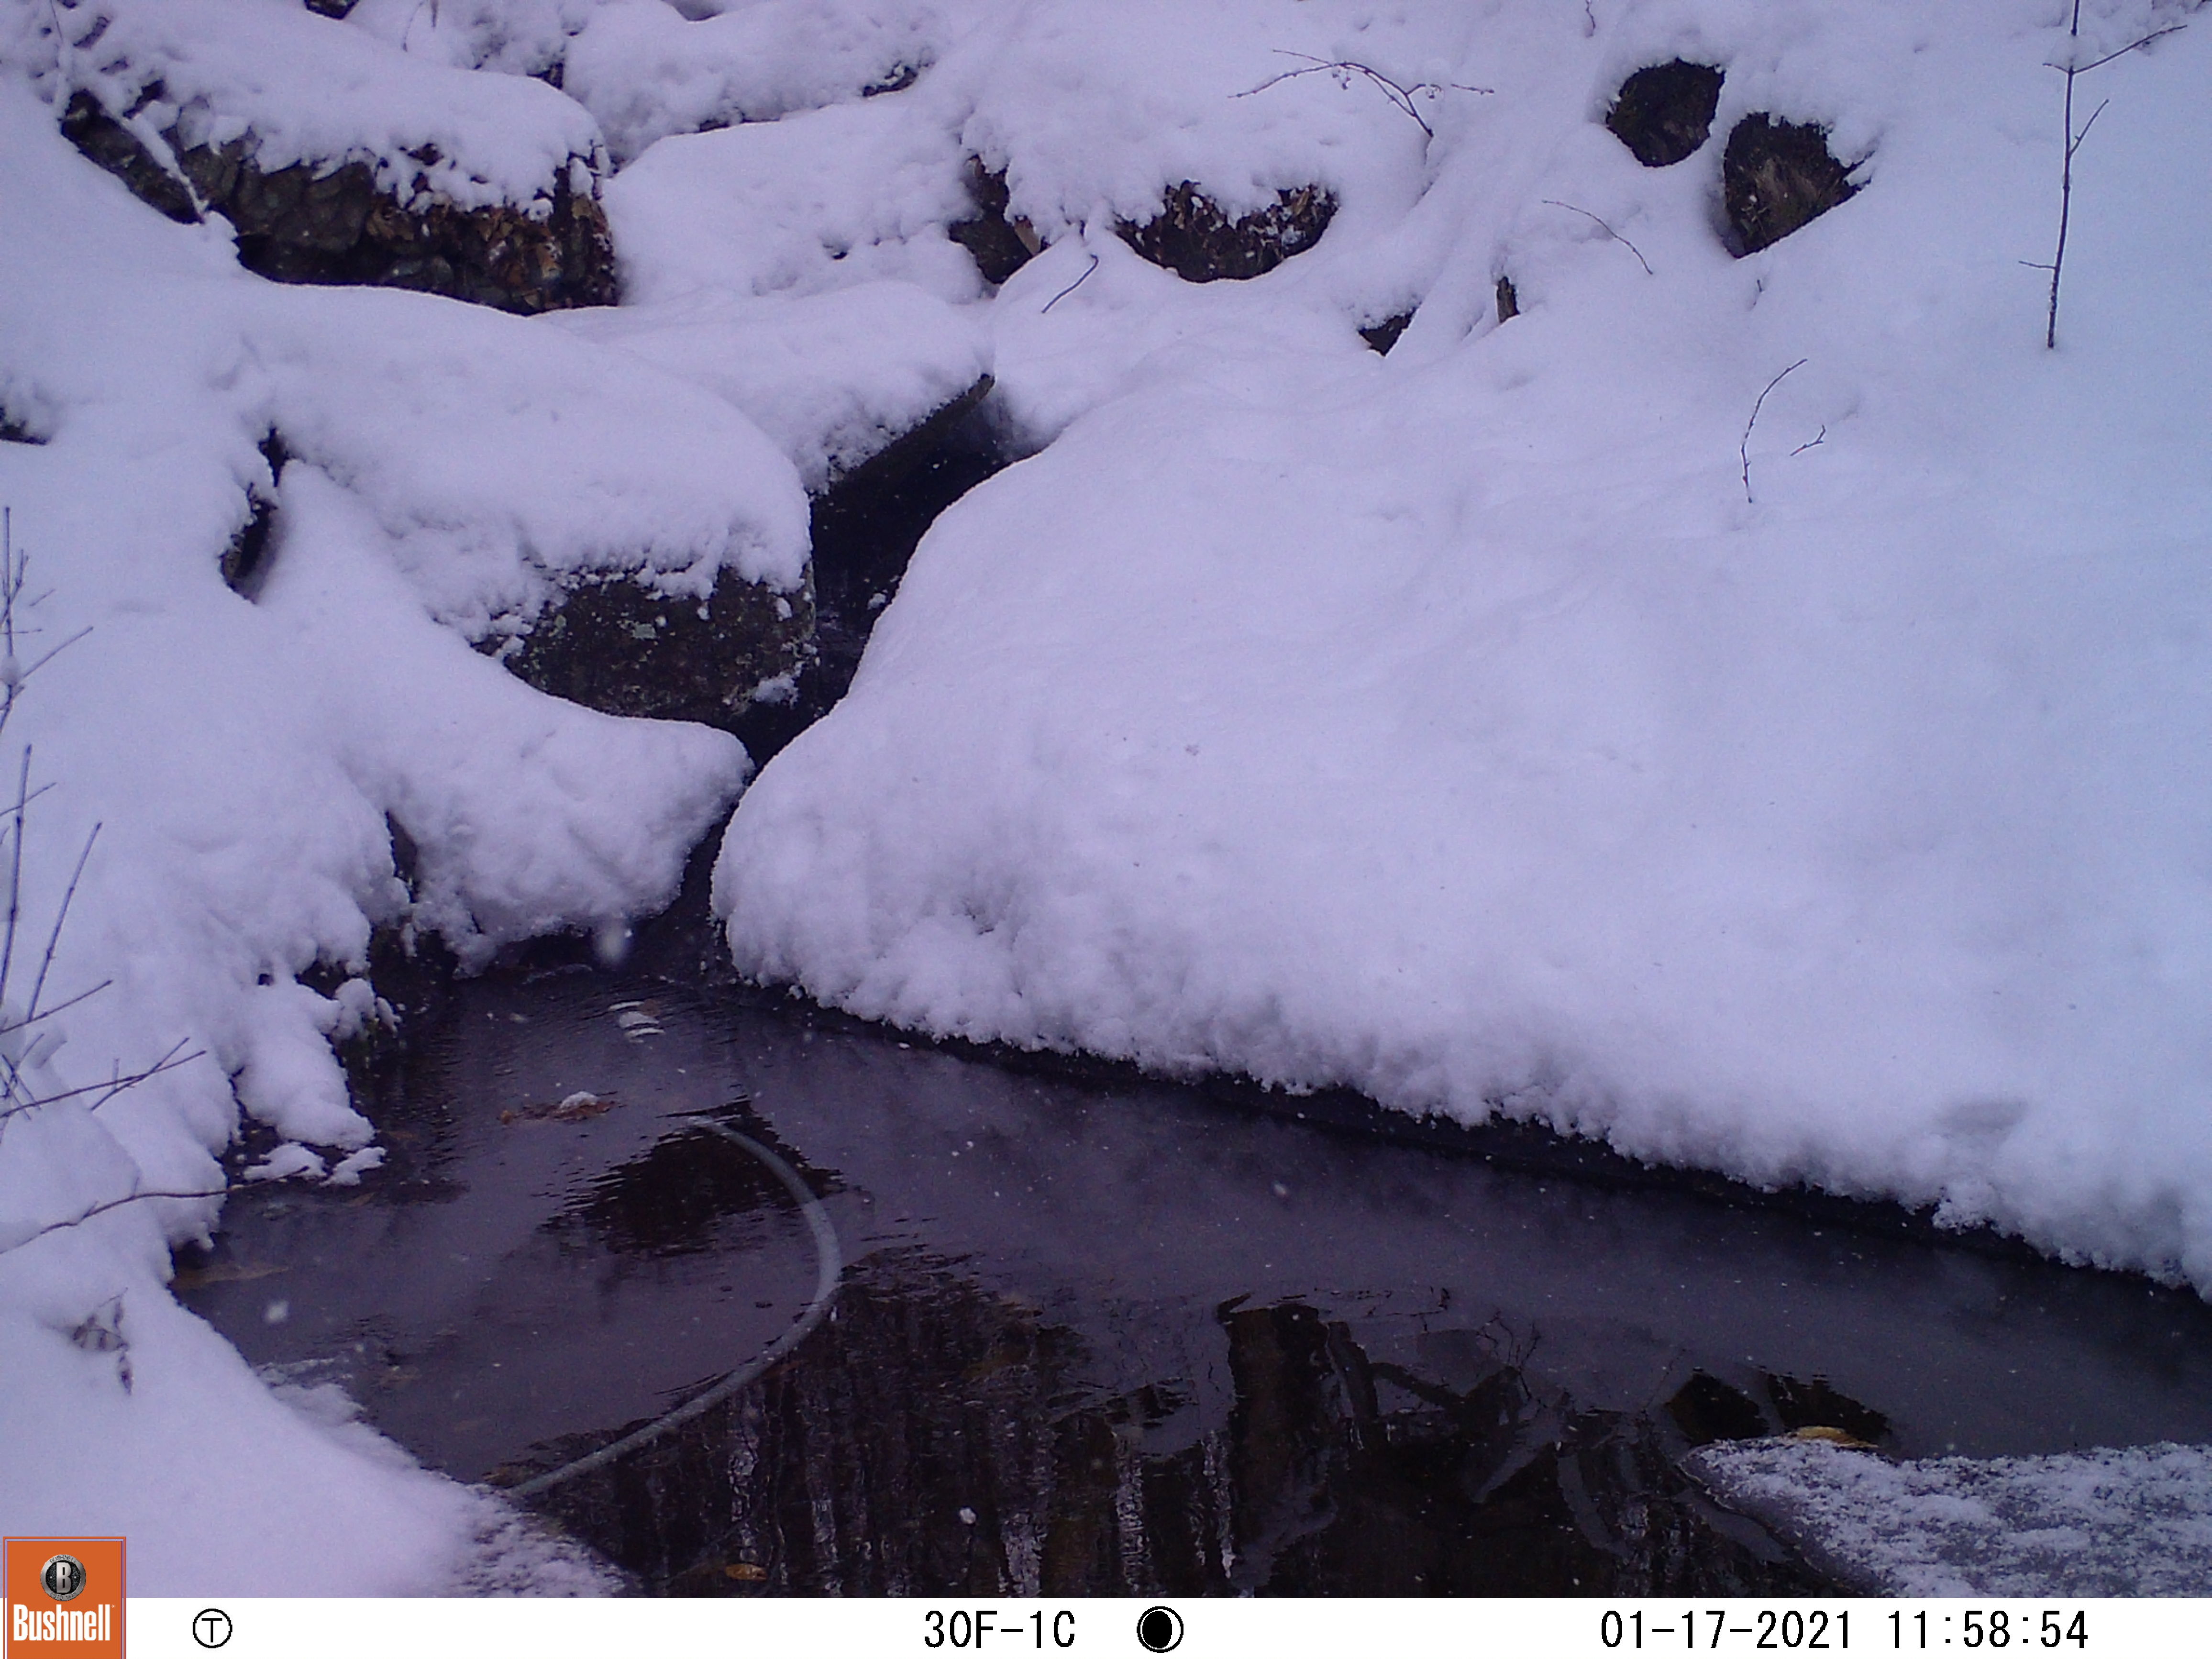

In [85]:
# View images not processed
from os.path import exists
from IPython.display import Image
path = "/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Newly_uploaded_data/W1 GC Channel 11-7-20  thru 5-9-21/01170148.JPG"
file_exists = exists(path)
print("file_exists:" , file_exists)
Image(path)

In [88]:
extract_timeStamp(path)

 

Correct timestamp not found
